# 1.Sử dụng các checkpoint đã huấn luyện để đoán nhận dữ liệu

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu đoán nhận
# là bộ dữ liệu hiện tại, được tạo trong lần đoán nhận này (tên file là lần đoán nhận này)
# sẽ trộn cả 2 bộ để đem ra đoán, nếu muốn đoán nhận từng bộ riêng lẻ thì comment lại bộ khác
# dùng model hiện tại để doán nhận bộ dữ liệu hiện tại => 2 bộ dưới là 2 bộ dữ liệu hiện tại
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w07-ftp-01-label',
    'nsm-2023w07-dos-02-label',
]))

In [2]:
#@title Nhập tên các checkpoint
# dòng đầu tiên, 2023W0702, là checkpoint hiện tại
# dòng thứ 2 trở đi, 2023W0701 ...., là các checkpoint quá khứ để đoán dữ liệu hiện tại là 2023W0702
# mỗi dòng, checkpoint là một model version được tải lên để đoán nhận các bộ dữ liệu L_source ở bên trên.
checkpoints = [
    '2023W0702',
    '2023W0701'
]

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-02-20 17:27:45.240334: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 17:27:47.410836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-20 17:27:47.411963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-20 17:27:47.413020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [4]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pandas as pd
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from tensorflow import keras

import common
from anomaly_normalization import LABEL
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, IMG, read_csv_in_dir

run, client = common.init_experiment(name='notebook')


2023-02-20 17:27:50,559[INFO][139704669001536-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()']) // n_timesteps_in
predict_size = total_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

(_prepare_read pid=39930) 2023-02-20 17:27:53,831	WARNING file_meta_provider.py:161 -- Expanding 2 path(s). This may be a HIGH LATENCY operation on some cloud storage services. If the specified paths all point to files and never directories, try rerunning this read with `meta_provider=FastFileMetadataProvider()`.
Shuffle Reduce: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

,label,count()
0,0.0,9109
1,1.0,3765


## Data preview

### L_train preview

In [7]:
L_predict[[LABEL, *features]]

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.800388,0.0,1.0,0.0,0.0,0.516408,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,-1.000000,1.0,0.995287,1.000000,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999998,0.958283,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.999988,1.0,1.0,1.0,1.0,1.0,1.0,0.999329,1.000000,0.0,1.0,0.0,0.0,0.891373,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.999988,1.0,1.000000,0.761594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,0.999998,0.0,1.0,0.999998,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.926227,0.0,1.0,0.0,0.0,0.858000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.993961,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.853440,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.989061,0.0,1.0,0.0,0.0,0.821040,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.999876,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.977707,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.969769,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.999529,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.969769,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.999988,0.0,0.0,1.0,0.0,0.0,1.0,0.761594,0.0,0.0,0.761594,0.0,1.0,0.0
12796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.999977,0.0,1.0,0.0,0.0,0.694783,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,0.999998,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.999996,0.0,1.

In [8]:
L_predict[[LABEL, *features]].describe()

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
count,12800.000000,12800.0,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.0,12800.000000,12800.0,12800.0,12800.000000,12800.0,12800.0,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,1.280000e+04,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.0,12800.0,12800.0,12800.000000,12800.000000,12800.000000,12800.0,12800.0,1.280000e+04,12800.0,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.000000,12800.0,12800.0,12800.0,12800.000000,12800.000000,12800.0,12800.000000,12800.0,12800.0,12800.000000,12800.000000,12800.000000,12800.0,12800.000000,12800.0,12800.000000,12800.000000,12800.000000,12800.0,12800.0
mean,0.294141,0.0,0.050000,0.050000,0.049979,0.050000,0.115859,0.115859,0.868203,0.498047,0.498047,0.454362,0.497994,0.498047,0.868203,0.868203,0.868203,0.486746,0.115803,0.767550,0.0,0.868203,0.0,0.0,0.650938,1.0,0.0,0.722146,0.983047,0.983047,0.767656,0.767656,0.678814,0.767628,0.899108,0.840779,0.085469,0.085469,1.000000e+00,0.623828,0.623828,0.597542,0.623828,0.623828,1.0,1.0,1.0,0.691465,0.085444,0.864159,0.0,1.0,1.000000e+00,0.0,0.121563,0.121563,0.121563,0.121484,0.785388,0.937419,1.0,1.0,1.0,0.964110,0.964116,1.0,0.999988,0.0,0.0,0.999922,0.868203,0.801962,1.0,0.939205,0.0,0.801962,0.939205,0.868203,1.0,0.0
std,0.455673,0.0,0.217953,0.217953,0.217870,0.217953,0.320069,0.320069,0.338283,0.500016,0.500016,0.533841,0.499987,0.500016,0.338283,0.338283,0.338283,0.492749,0.319912,0.388247,0.0,0.338283,0.0,0.0,0.296335,0.0,0.0,0.168789,0.129101,0.129101,0.422344,0.422344,0.542490,0.422335,0.239867,0.260591,0.279589,0.279589,4.966734e-08,0.484443,0.484443,0.508700,0.484443,0.484443,0.0,0.0,0.0,0.445379,0.279508,0.280532,0.0,0.0,5.435566e-08,0.0,0.326793,0.326793,0.326793,0.326702,0.410566,0.242211,0.0,0.0,0.0,0.185541,0.185882,0.0,0.000003,0.0,0.0,0.008839,0.338283,0.327961,0.0,0.098563,0.0,0.327961,0.098563,0.338283,0.0,0.0
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.999998e-01,0.000000,0.000000,-1.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,1.0,9.999998e-01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,1.0,0.999988,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.761594,0.0,0.000000,0.761594,0.000000,1.0,0.0
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0

In [9]:
DataFrame.from_records(LX_predict[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,0.800388,0.0,1.0,0.0,0.0,0.516408,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,-1.000000,1.0,0.995287,1.000000,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999998,0.958283,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.999988,1.0,1.0,1.0,1.0,1.0,1.000000,0.999329,1.000000,0.0,1.0,0.0,0.0,0.891373,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.999988,1.0,1.000000,0.761594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,0.999998,0.0,1.0,0.999998,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,0.926227,0.0,1.0,0.0,0.0,0.858000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.993961,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.853440,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,0.989061,0.0,1.0,0.0,0.0,0.821040,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.999876,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.977707,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.969769,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.999529,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.969769,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.559741,0.000000,0.393940,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.682035,0.999909,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.393940,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,0.942803,0.0,1.0,0.0,0.0,0.880797,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.995440,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.855938,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.969964,0.0,1.0,0.0,0.0,0.957009,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.996597,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.798930,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.000000,1.0,1.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.963845,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.999322,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.963845,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,

In [10]:
DataFrame.from_records(LX_predict[0]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
count,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.000000,100.0,100.0,1.000000e+02,1.000000e+02,100.0,100.0,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.0,100.0,100.0,100.0,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0
mean,0.0,0.090000,0.090000,0.090000,0.090000,0.180000,0.180000,1.0,0.870000,0.870000,0.789618,0.870000,0.870000,1.0,1.0,1.0,0.754853,0.179906,0.885766,0.0,1.0,0.0,0.0,0.799190,1.0,0.0,7.615942e-01,1.000000e+00,1.0,1.0,1.0,0.799934,1.0,0.954620,0.898785,0.060000,0.060000,1.0,0.880000,0.880000,0.797566,0.880000,0.880000,1.0,1.0,1.0,0.932009,0.059987,0.855071,0.0,1.0,1.0,0.0,0.290000,0.290000,0.290000,0.290000,1.000000e+00,1.0,1.0,1.0,1.0,0.949752,0.949999,1.0,0.999988,0.0,0.0,1.0,1.0,0.991073,1.0,0.991358,0.0,0.991073,0.991358,1.0,1.0,0.0
std,0.0,0.287623,0.287623,0.287623,0.287623,0.386123,0.386123,0.0,0.337998,0.337998,0.498231,0.337998,0.337998,0.0,0.0,0.0,0.421709,0.385921,0.196805,0.0,0.0,0.0,0.0,0.168436,0.0,0.0,2.231632e-16,2.231632e-17,0.0,0.0,0.0,0.603001,0.0,0.110196,0.226439,0.238683,0.238683,0.0,0.326599,0.326599,0.491944,0.326599,0.326599,0.0,0.0,0.0,0.244307,0.238630,0.210989,0.0,0.0,0.0,0.0,0.456048,0.456048,0.456048,0.456048,7.849859e-11,0.0,0.0,0.0,0.0,0.219000,0.219043,0.0,0.000000,0.0,0.0,0.0,0.0,0.034818,0.0,0.034709,0.0,0.034818,0.034709,0.0,0.0,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,-1.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.194987,0.0,1.0,0.0,0.0,0.202698,1.0,0.0,7.615942e-01,1.000000e+00,1.0,1.0,1.0,-1.000000,1.0,0.375691,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,-1.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.194987,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.0,1.0,1.0,1.0,0.000000,0.000000,1.0,0.999988,0.0,0.0,1.0,1.0,0.761594,1.0,0.761594,0.0,0.761594,0.761594,1.0,1.0,0.0
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.999988,1.000000,1.000000,1.0,1.0,1.0,0.664447,0.000000,0.879373,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,7.615942e-01,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,0.986043,0.964028,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.000000,0.768857,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,0.999988,0.0,1.000000,0.999988,1.0,1.0,0.0
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.000000,0.987848,0.0,1.0,0.0,0.0,0.813569,1.0,0.0,7.615942e-01,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,0.999840,0.999329,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.000000,0.977583,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.0
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.891373,1.0,0.0,7.615942e-01,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.0,

In [11]:
DataFrame.from_records(Ly_predict)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
124,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
125,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
126,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

In [12]:
DataFrame.from_records(Ly_predict).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.289062,0.296875,0.296875,0.296875,0.289062,0.296875,0.289062,0.312500,0.289062,0.289062,0.304688,0.312500,0.304688,0.296875,0.296875,0.289062,0.312500,0.320312,0.320312,0.296875,0.304688,0.296875,0.312500,0.320312,0.304688,0.296875,0.296875,0.304688,0.289062,0.304688,0.304688,0.296875,0.289062,0.281250,0.296875,0.296875,0.289062,0.296875,0.281250,0.296875,0.289062,0.296875,0.273438,0.281250,0.289062,0.289062,0.289062,0.281250,0.281250,0.289062,0.296875,0.281250,0.296875,0.289062,0.281250,0.273438,0.289062,0.296875,0.289062,0.289062,0.281250,0.273438,0.296875,0.296875,0.296875,0.304688,0.304688,0.304688,0.281250,0.304688,0.304688,0.296875,0.296875,0.296875,0.289062,0.281250,0.304688,0.281250,0.281250,0.281250,0.289062,0.289062,0.304688,0.304688,0.289062,0.289062,0.304688,0.304688,0.304688,0.289062,0.296875,0.289062,0.296875,0.281250,0.289062,0.281250,0.289062,0.281250,0.289062,0.289062
std,0.455108,0.458676,0.458676,0.458676,0.455108,0.458676,0.455108,0.465334,0.455108,0.455108,0.462084,0.465334,0.462084,0.458676,0.458676,0.455108,0.465334,0.468430,0.468430,0.458676,0.462084,0.458676,0.465334,0.468430,0.462084,0.458676,0.458676,0.462084,0.455108,0.462084,0.462084,0.458676,0.455108,0.451376,0.458676,0.458676,0.455108,0.458676,0.451376,0.458676,0.455108,0.458676,0.447475,0.451376,0.455108,0.455108,0.455108,0.451376,0.451376,0.455108,0.458676,0.451376,0.458676,0.455108,0.451376,0.447475,0.455108,0.458676,0.455108,0.455108,0.451376,0.447475,0.458676,0.458676,0.458676,0.462084,0.462084,0.462084,0.451376,0.462084,0.462084,0.458676,0.458676,0.458676,0.455108,0.451376,0.462084,0.451376,0.451376,0.451376,0.455108,0.455108,0.462084,0.462084,0.455108,0.455108,0.462084,0.462084,0.462084,0.455108,0.458676,0.455108,0.458676,0.451376,0.455108,0.451376,0.455108,0.451376,0.455108,0.455108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

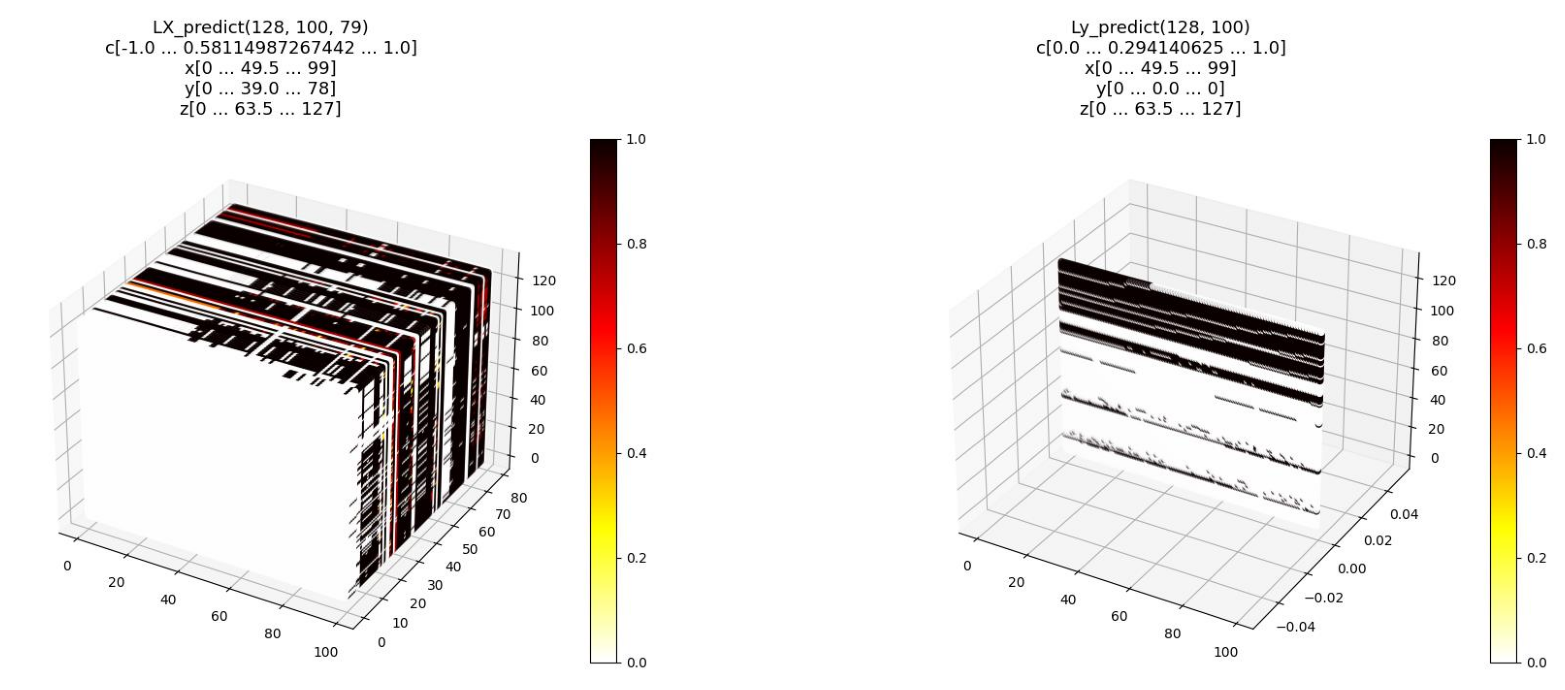

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [15]:
# threshold(num) là ngưỡng quyết định kết quả dữ đoán là anomaly hay benign, ví dụ: 0.5 ở đây là
# nếu kết quả dự đoán > 0.5 thì xem là anomaly, còn lại là benign, kết quả dự đoán của 1 flow
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    
    actual = predicted.ravel()
    expected = Ly_predict.ravel()
    anomaly_detected = anomaly_incorrect = benign_detected = benign_incorrect = 0
    for i in range(0, len(actual)):
        anomaly_detected += actual[i] == expected[i] == 1
        anomaly_incorrect += (actual[i] == 0) & (expected[i] == 1)
        benign_detected += actual[i] == expected[i] == 0
        benign_incorrect += (actual[i] == 1) & (expected[i] == 0)
    
    df = DataFrame.from_dict({
        'checkpoint': [checkpoint],
        'anomaly_detected': [anomaly_detected],
        'anomaly_incorrect': [anomaly_incorrect],
        'benign_detected': [benign_detected],
        'benign_incorrect': [benign_incorrect],
        'detected': [anomaly_detected + benign_detected],
        'incorrect': [anomaly_incorrect + benign_incorrect],
        'detected_rate': [(anomaly_detected + benign_detected) / len(actual)],
        'incorrect_rate': [(anomaly_incorrect + benign_incorrect) / len(actual)],
    })    
    print(df.to_string())

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])
    
    return df

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



2023-02-20 17:30:53.955340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-20 17:30:53.956115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-20 17:30:53.956843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-02-20 17:30:53.957556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W0702              3224                541             8612               423     11836        964       0.924687        0.075313


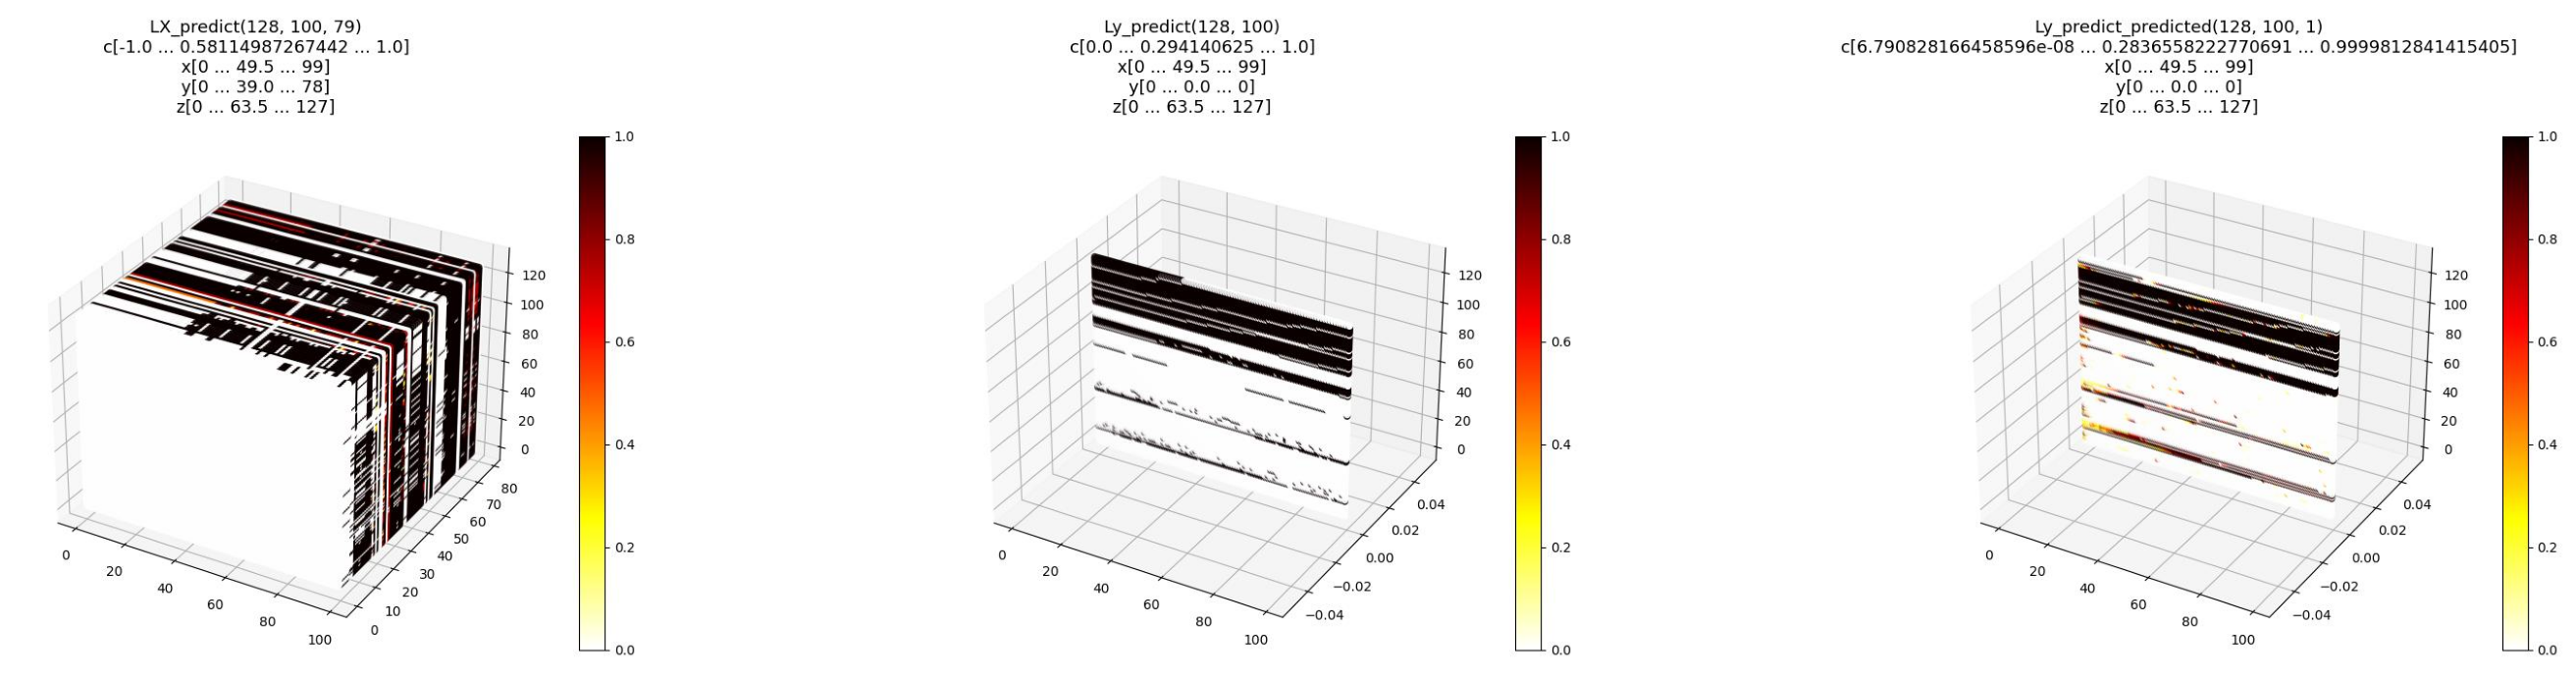

  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W0701              3210                555             8988                47     12198        602       0.952969        0.047031


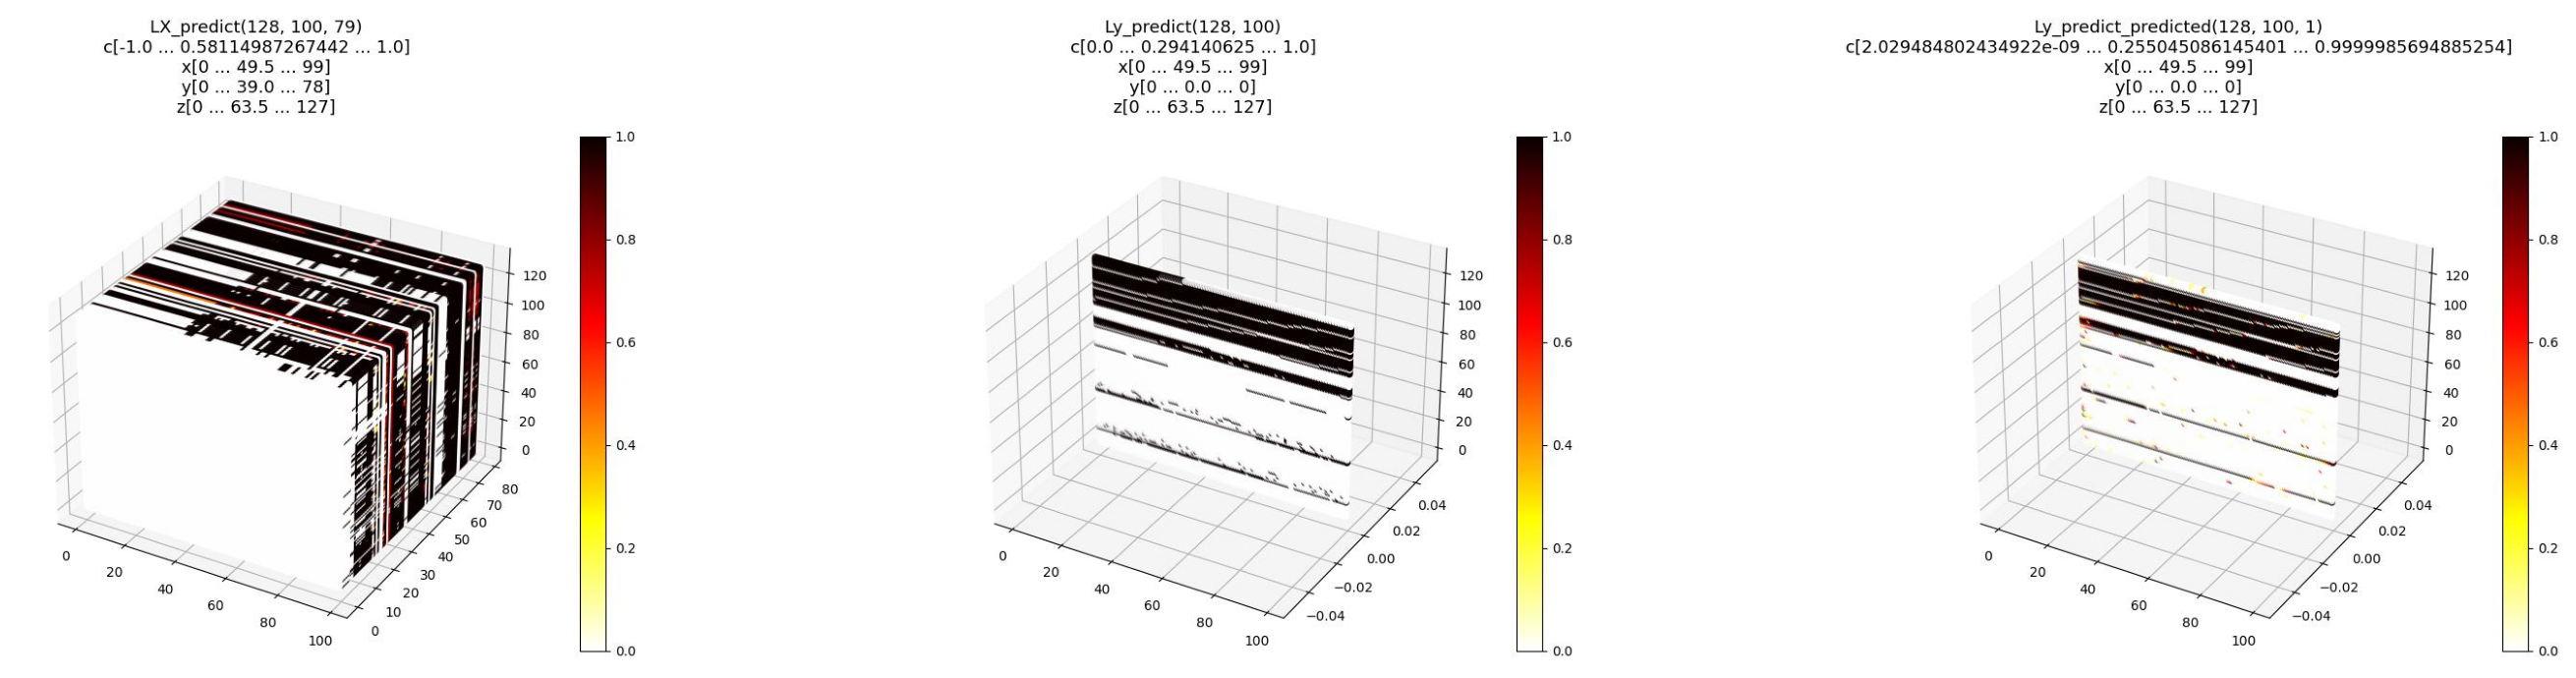

,checkpoint,anomaly_detected,anomaly_incorrect,benign_detected,benign_incorrect,detected,incorrect,detected_rate,incorrect_rate
0,2023W0702,3224,541,8612,423,11836,964,0.924687,0.075313
1,2023W0701,3210,555,8988,47,12198,602,0.952969,0.047031


In [16]:
df = DataFrame()
for c in checkpoints:
    dfc = infer_by_checkpoint(c)
    df = pd.concat([df, dfc], axis=0, ignore_index=True)
df